In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import Sequential,Model
from keras.layers import concatenate,Activation, Dense, Dropout, Conv2D, Flatten, MaxPooling2D, GlobalMaxPooling2D, GlobalAveragePooling1D,\
     AveragePooling2D, Input, Add, BatchNormalization, Reshape, TimeDistributed, Conv1D, LSTM, Permute, Concatenate
from keras.preprocessing.image import ImageDataGenerator
from keras.models import model_from_json
from sklearn.metrics import roc_curve
from keras.utils import np_utils
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa 
import librosa.display
import pylab
import cv2
import os

---
# 1-Prepare Data
---



In [3]:
rt_dir = 'E:\\Coswara-Data-master'
import glob
for each in os.listdir(rt_dir):
    if os.path.isdir(os.path.join(rt_dir,each)) and each != '.git':
        print(os.path.join(rt_dir, each,''))
        !type {os.path.join(rt_dir, each,'')}*.tar.gz.* > {os.path.join(rt_dir, each,'')}combined_file.tar.gz
        !C://Users/Admin/Downloads/WinRAR/unrar x {os.path.join(rt_dir, each,'')}combined_file.tar.gz -C {rt_dir}
subset = glob.glob('./Coswara-Data/*/*.tar.gz.*') + glob.glob('./Coswara-Data/*/combined_data.tar.gz')
[os.remove(x) for x in subset];

In [5]:
names   = ['ID','Fever/MP','ORC','STATUS','DIR','DataSet']
join_by = pd.read_csv('E:\\Coswara-Data-master\\combined_data.csv')

import glob
df_list = []
for path in tqdm(glob.glob('E:\\Coswara-Data-master\\*\\*\\*\\cough-shallow.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('\\')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData=pd.concat(df_list)
CosData['DataSet'] = 'coswara'
CosData.head()

100%|██████████| 2232/2232 [00:16<00:00, 137.81it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,0gB18cWHioTobGuU3qVE0QV5mBN2,healthy,E:\Coswara-Data-master\20200415\20200415\0gB18...,0,0,coswara
0,0KOy96zEUfdMY4rZzwrDT0gMPDa2,healthy,E:\Coswara-Data-master\20200415\20200415\0KOy9...,0,0,coswara
0,1j2LqFPOJIQ8nTlovQqNr6bdUMl1,healthy,E:\Coswara-Data-master\20200415\20200415\1j2Lq...,0,0,coswara
0,1kj3twlB9PcVyePxzqNGwnkYZZx2,healthy,E:\Coswara-Data-master\20200415\20200415\1kj3t...,0,0,coswara
0,1pXSBzMeizcu5IpLAJUaYpmJyhB3,healthy,E:\Coswara-Data-master\20200415\20200415\1pXSB...,0,0,coswara


In [6]:
join_by = join_by.loc[join_by['covid_status']!='healthy']
for path in tqdm(glob.glob('E:\\Coswara-Data-master\\*\\*\\*\\cough-heavy.wav')):
  temp = pd.DataFrame(columns=['id','DIR'])
  temp['id'] = [path.split('\\')[-2]]
  temp['DIR'] = [path]
  temp = pd.merge(left=temp,right=join_by,on='id',how='inner')

  temp['fomp']= (temp['fever']| temp['mp']).apply(int)
  temp['oths']= (temp['cld']|temp['asthma']|temp['cold']|temp['st']|temp['pneumonia']).apply(int)
  temp        = temp[['id','covid_status','DIR','fomp','oths']]
  df_list.append(temp.rename(columns={'id':'ID','covid_status':'STATUS','DIR':'DIR','fomp':'Fever/MP','oths':'ORC'}))
CosData2=pd.concat(df_list)
CosData2['DataSet'] = 'coswara'
CosData2.head()

100%|██████████| 2233/2233 [00:15<00:00, 148.19it/s]


,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,0gB18cWHioTobGuU3qVE0QV5mBN2,healthy,E:\Coswara-Data-master\20200415\20200415\0gB18...,0,0,coswara
0,0KOy96zEUfdMY4rZzwrDT0gMPDa2,healthy,E:\Coswara-Data-master\20200415\20200415\0KOy9...,0,0,coswara
0,1j2LqFPOJIQ8nTlovQqNr6bdUMl1,healthy,E:\Coswara-Data-master\20200415\20200415\1j2Lq...,0,0,coswara
0,1kj3twlB9PcVyePxzqNGwnkYZZx2,healthy,E:\Coswara-Data-master\20200415\20200415\1kj3t...,0,0,coswara
0,1pXSBzMeizcu5IpLAJUaYpmJyhB3,healthy,E:\Coswara-Data-master\20200415\20200415\1pXSB...,0,0,coswara


## Prepare dataset

In [7]:
custpath  = 'E://virufy_code-main/image_mfcc/' #Where mfcc image will be stored

TotData   = pd.concat([CosData, CosData2])
TotData.head()

,ID,STATUS,DIR,Fever/MP,ORC,DataSet
0,ZuysSjckdLWhDEc9mARQwWpXfIj2,healthy,E:\Coswara-Data-master\20201031\20201031\ZuysS...,0,0,coswara
1,EuEoeANAhadcy5vzBikn3LxlGKh1,positive_mild,E:\Coswara-Data-master\20210816\20210816\EuEoe...,0,1,coswara
2,iOx0zPyPiMZjCWXuf3RGu8HKq8k1,positive_mild,E:\Coswara-Data-master\20210630\20210630\iOx0z...,0,0,coswara
3,Eg87yvzTcTOSRHlObK3w0ju4Ej82,positive_mild,E:\Coswara-Data-master\20210630\20210630\Eg87y...,0,0,coswara
4,2n0fnSeTNiWvPi7aLxRrFsCGU8D2,healthy,E:\Coswara-Data-master\20200424\20200424\2n0fn...,0,0,coswara


## Feature Extraction

In [8]:
TotData['STATUS'].value_counts()

healthy              1246
positive_mild         783
positive_moderate     354
positive_asymp        153
Name: STATUS, dtype: int64

In [10]:
def feature_extractor(row):
  
  name     = row[0]
  try:
    audio,sr = librosa.load(row[-4])
    hop_length = np.floor(0.010*sr).astype(int) #10ms
    win_length = np.floor(0.020*sr).astype(int) #20ms 
    if(audio.shape > (0,)):
      #For MFCCS 
      mfccs    = librosa.feature.mfcc(y=audio,sr=sr, n_mfcc=13,hop_length=hop_length,win_length=win_length)
      mfccsscaled = np.mean(mfccs.T,axis=0)
      
      #Mel Spectogram
      pylab.axis('off') # no axis
      pylab.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])
      s_db     = librosa.power_to_db(mfccs, ref=np.max)
      librosa.display.specshow(s_db)

      savepath = os.path.join(custpath,name+'.png')
      pylab.savefig(savepath, bbox_inches=None, pad_inches=0)
      # pylab.show()
      pylab.close()
  except:
    print('File cannot open: ' + row[-4])
    return None,None
  return mfccsscaled,savepath

features = []
diagnoses= []
imgpaths = []

In [11]:
!mkdir E:\\virufy_code-main\\image_mfcc

A subdirectory or file E:\\virufy_code-main\\image_mfcc already exists.


In [12]:
for row in tqdm(TotData.values):
  mfccs,savepath  = feature_extractor(row)
  features.append(mfccs)
  imgpaths.append(savepath)
  diagnoses.append([row[3],row[4]])

  1%|          | 23/2536 [00:08<11:50,  3.54it/s] 

File cannot open: E:\Coswara-Data-master\20200820\20200820\Tfvspm3rapd3ZLyAoMG36VxNQnr2\cough-shallow.wav


  3%|▎         | 67/2536 [00:27<21:19,  1.93it/s]

File cannot open: E:\Coswara-Data-master\20210816\20210816\WcRpZenx0WWQmzOUPTHEEGlyJAg1\cough-shallow.wav


  9%|▉         | 226/2536 [01:30<13:54,  2.77it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\VxQekDvwa3N5B2FqB4FlQ5jBjTp2\cough-shallow.wav


 12%|█▏        | 311/2536 [02:10<18:49,  1.97it/s]

File cannot open: E:\Coswara-Data-master\20200419\20200419\XFX3DxpzWlTsqde0wmliVzvRXnf1\cough-shallow.wav


 14%|█▍        | 353/2536 [02:25<13:08,  2.77it/s]

File cannot open: E:\Coswara-Data-master\20200415\20200415\jSb7SyucSmTHhzs3qQoBExRMQZ02\cough-shallow.wav


 16%|█▋        | 418/2536 [02:56<10:40,  3.31it/s]

File cannot open: E:\Coswara-Data-master\20210930\20210930\fxKtohOugAVxds721TRXR8GVmn02\cough-heavy.wav


 21%|██        | 533/2536 [03:40<09:31,  3.50it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\FJTHLyF7sGYFJpundI1mZ28HQQ03\cough-shallow.wav


 29%|██▉       | 733/2536 [05:01<08:04,  3.72it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\mNcNjQMsv8aZXFGuguWbLdmkOQk2\cough-shallow.wav


 31%|███       | 787/2536 [05:24<09:25,  3.09it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\I5gTlFVoKbVFGCKxwV6QXSOdkZN2\cough-shallow.wav


 33%|███▎      | 840/2536 [05:45<10:47,  2.62it/s]

File cannot open: E:\Coswara-Data-master\20210714\20210714\dpA0EeRrtJUeKJjEuf7BL0AeTJZ2\cough-shallow.wav


 36%|███▌      | 918/2536 [06:21<14:02,  1.92it/s]

File cannot open: E:\Coswara-Data-master\20210714\20210714\dpA0EeRrtJUeKJjEuf7BL0AeTJZ2\cough-shallow.wav


 38%|███▊      | 968/2536 [06:51<15:45,  1.66it/s]

File cannot open: E:\Coswara-Data-master\20200415\20200415\jSb7SyucSmTHhzs3qQoBExRMQZ02\cough-shallow.wav


 44%|████▍     | 1126/2536 [08:12<08:27,  2.78it/s]

File cannot open: E:\Coswara-Data-master\20200419\20200419\XFX3DxpzWlTsqde0wmliVzvRXnf1\cough-shallow.wav


 55%|█████▍    | 1393/2536 [10:23<07:23,  2.58it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\FJTHLyF7sGYFJpundI1mZ28HQQ03\cough-shallow.wav


 65%|██████▌   | 1651/2536 [12:03<05:57,  2.47it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\mNcNjQMsv8aZXFGuguWbLdmkOQk2\cough-shallow.wav


 65%|██████▌   | 1656/2536 [12:04<03:48,  3.85it/s]

File cannot open: E:\Coswara-Data-master\20200820\20200820\Tfvspm3rapd3ZLyAoMG36VxNQnr2\cough-shallow.wav


 71%|███████   | 1801/2536 [12:57<04:23,  2.79it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\VxQekDvwa3N5B2FqB4FlQ5jBjTp2\cough-shallow.wav


 73%|███████▎  | 1855/2536 [13:14<03:26,  3.29it/s]

File cannot open: E:\Coswara-Data-master\20200820\20200820\aU8pLZV1OUQJV0GKeeIlgWhYWeA2\cough-shallow.wav


 84%|████████▍ | 2142/2536 [15:05<02:16,  2.88it/s]

File cannot open: E:\Coswara-Data-master\20200502\20200502\I5gTlFVoKbVFGCKxwV6QXSOdkZN2\cough-shallow.wav


 90%|████████▉ | 2278/2536 [15:53<01:17,  3.32it/s]

File cannot open: E:\Coswara-Data-master\20210816\20210816\WcRpZenx0WWQmzOUPTHEEGlyJAg1\cough-shallow.wav


 98%|█████████▊| 2474/2536 [17:05<00:20,  3.03it/s]

File cannot open: E:\Coswara-Data-master\20200820\20200820\aU8pLZV1OUQJV0GKeeIlgWhYWeA2\cough-shallow.wav


100%|█████████▉| 2531/2536 [17:24<00:01,  3.10it/s]C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:222: UserWarning: n_fft=2048 is too small for input signal of length=1882
  warnings.warn(
100%|██████████| 2536/2536 [17:25<00:00,  2.43it/s]


---
# 2- Data Sampling 
---

## Remove Nans





In [13]:
isnone = lambda x: x is not None
label  = lambda x: 1 if x == 'positive_mild' or x =='positive_moderate' or x == 'positive_asymp' or x == 'COVID-19' else 0
cast_x = list(map(isnone,imgpaths))
data_y = list(map(label,TotData['STATUS']))

print(len(imgpaths))

data_x = [features[i] for i in range(len(features)) if cast_x[i] == True]
data_xx= [imgpaths[i] for i in range(len(imgpaths)) if cast_x[i] == True]
data_xp= [diagnoses[i]for i in range(len(diagnoses))if cast_x[i] == True]
data_y = [data_y[i] for i in range(len(features)) if cast_x[i] == True]

2536


In [14]:
(np.array(data_y) == 1).sum()

1287

## Prepare Data Splits
  n = NUM_shuf





In [ ]:
# assert len(data_x) == len(data_xx) == len(data_xp), "Data lengths do not match"

indices = np.arange(len(data_xx))
print(indices)
NUM_shuf= 5
DATA    = {i:{} for i in range(NUM_shuf)}
print(DATA)

for i in range(NUM_shuf):
  np.random.shuffle(indices)

  DATA[i]['MFCCS'] = np.array([data_x[i] for i in indices])
  DATA[i]['MEL']   = [data_xx[i] for i in indices]
  DATA[i]['EXTRA'] = np.array([data_xp[i] for i in indices])
  DATA[i]['LABELS']= np.array([data_y[i] for i in indices])

print(DATA[0])

In [16]:
# Save extracted features
# Note: mel specs not saved
import pickle
pickle.dump( DATA, open( "loaded_data.pickle", "wb" ) )

## Data Generator




In [17]:
class CustomDataset(tf.keras.utils.Sequence):
  def __init__(self,imgfiles,labels,batch_size,target_size=(224,224),shuffle=False,scale=255,n_classes=1,n_channels=3):
    self.batch_size = batch_size
    self.dim        = target_size
    self.labels     = labels
    self.imgfiles   = imgfiles
    self.n_classes  = n_classes
    self.shuffle    = shuffle
    self.n_channels = n_channels
    self.scale      = scale

    self.c          = 0
    self.on_epoch_end()

  def __len__(self):
    # returns the number of batches
    return int(np.floor(len(self.imgfiles) / self.batch_size))

  def __getitem__(self, index):
    # returns one batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    # Generate data
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.imgfiles))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)
  
  def __data_generation(self, list_IDs_temp):
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(list_IDs_temp):
        # Store sample
        img   = cv2.imread(self.imgfiles[ID])
        img   = cv2.resize(img,self.dim,interpolation = cv2.INTER_CUBIC)
        X[i,] = img / self.scale

        # Store class
        y[i] = self.labels[ID]

        self.c +=1
    return X, y #keras.utils.to_categorical(y, num_classes=self.n_classes)


class CustomPipeline(tf.keras.utils.Sequence):
  def __init__(self,data_x,data_y,batch_size=64,shuffle=False,n_classes=1):
    self.features   = data_x
    self.labels     = data_y
    self.batch_size = 64
    self.shuffle    = shuffle
    self.n_features = self.features.shape[1]
    self.n_classes  = 1
    self.on_epoch_end()

  def __len__(self):
    return int(np.floor(len(self.features) / self.batch_size))

  def __getitem__(self,index):
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    X, y = self.__data_generation(indexes)
    return X, y

  def on_epoch_end(self):
    self.indexes = np.arange(len(self.features))
    if self.shuffle == True:
      np.random.shuffle(self.indexes)

  def __data_generation(self,indexes):
    X = np.empty((self.batch_size, self.n_features))
    y = np.empty((self.batch_size), dtype=int)

    for i, ID in enumerate(indexes):
      X[i,] = self.features[ID]
      y[i,] = self.labels[ID]
    return X, y

class MultipleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)

  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X_batch = [X1_batch, X2_batch]
      return X_batch, Y_batch

class TripleInputGenerator(tf.keras.utils.Sequence):
  """Wrapper of two generatos for the combined input model"""

  def __init__(self, X1, X2, X3, Y, batch_size,target_size=(64,64)):
      self.genX1 = CustomPipeline(X1, Y, batch_size=batch_size,shuffle=False)
      self.genX2 = CustomDataset (X2, Y, batch_size=batch_size,shuffle=False,target_size=target_size)
      self.genX3 = CustomPipeline(X3, Y, batch_size=batch_size,shuffle=False)
  def __len__(self):
      return self.genX1.__len__()

  def __getitem__(self, index):
      X1_batch, Y_batch = self.genX1.__getitem__(index)
      X2_batch, Y_batch = self.genX2.__getitem__(index)
      X3_batch, Y_batch = self.genX3.__getitem__(index)

      X_batch = [X1_batch, X2_batch, X3_batch]
      return X_batch, Y_batch

---
# 3- Training and Evaluation
---

In [18]:
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss
from keras.callbacks import Callback
class Evaluation(keras.callbacks.Callback):
  
  def __init__(self, val_data_gen, val_labels, test_data_gen, test_labels):
    super(Callback, self).__init__()
    self.test_data = test_data_gen
    self.val_labels = val_labels
    self.val_data = val_data_gen
    self.test_labels = test_labels

  def on_epoch_end(self, epoch, logs=None):
    y_preds = self.model.predict(self.val_data)
    print(' | val_loss: ', log_loss(self.val_labels[:len(y_preds)], y_preds), ' | val_auc:', roc_auc_score(self.val_labels[:len(y_preds)], y_preds), ' | val_acc: ', accuracy_score(self.val_labels[:len(y_preds)], y_preds>0.5))

    y_preds = self.model.predict(self.test_data)
    print(' | test_loss: ', log_loss(self.test_labels[:len(y_preds)], y_preds),' | test_auc:', roc_auc_score(self.test_labels[:len(y_preds)], y_preds), ' | test_acc: ', accuracy_score(self.test_labels[:len(y_preds)], y_preds>0.5))


In [19]:
from tensorflow.keras.layers import Conv2D, BatchNormalization,  MaxPooling2D, ReLU, Add, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model, layers

class ResBlock(Model):
    def __init__(self, channels, stride=1):
        super(ResBlock, self).__init__(name='ResBlock')
        self.flag = (stride != 1)
        self.conv1 = Conv2D(channels, 3, stride, padding='same')
        self.bn1 = BatchNormalization()
        self.conv2 = Conv2D(channels, 3, padding='same')
        self.bn2 = BatchNormalization()
        self.relu = ReLU()
        if self.flag:
            self.bn3 = BatchNormalization()
            self.conv3 = Conv2D(channels, 1, stride)

    def call(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.relu(x1)
        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        if self.flag:
            x = self.conv3(x)
            x = self.bn3(x)
        x1 = layers.add([x, x1])
        x1 = self.relu(x1)
        return x1


class ResNet34(Model):
    def __init__(self):
        super(ResNet34, self).__init__(name='ResNet34')
        self.conv1 = Conv2D(64, 7, 2, padding='same')
        self.bn = BatchNormalization()
        self.relu = ReLU()
        self.mp1 = MaxPooling2D(3, 2)

        self.conv2_1 = ResBlock(64)
        self.conv2_2 = ResBlock(64)
        self.conv2_3 = ResBlock(64)

        self.conv3_1 = ResBlock(128, 2)
        self.conv3_2 = ResBlock(128)
        self.conv3_3 = ResBlock(128)
        self.conv3_4 = ResBlock(128)

        self.conv4_1 = ResBlock(256, 2)
        self.conv4_2 = ResBlock(256)
        self.conv4_3 = ResBlock(256)
        self.conv4_4 = ResBlock(256)
        self.conv4_5 = ResBlock(256)
        self.conv4_6 = ResBlock(256)

        self.conv5_1 = ResBlock(512, 2)
        self.conv5_2 = ResBlock(512)
        self.conv5_3 = ResBlock(512)

        self.pool = GlobalAveragePooling2D()
        self.fc1 = Dense(512, activation='relu')
        self.dp1 = Dropout(0.5)
        self.fc2 = Dense(512, activation='relu')
        self.dp2 = Dropout(0.5)
        self.fc3 = Dense(64)

    def call(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = self.relu(x)
        x = self.mp1(x)

        x = self.conv2_1(x)
        x = self.conv2_2(x)
        x = self.conv2_3(x)

        x = self.conv3_1(x)
        x = self.conv3_2(x)
        x = self.conv3_3(x)
        x = self.conv3_4(x)

        x = self.conv4_1(x)
        x = self.conv4_2(x)
        x = self.conv4_3(x)
        x = self.conv4_4(x)
        x = self.conv4_5(x)
        x = self.conv4_6(x)

        x = self.conv5_1(x)
        x = self.conv5_2(x)
        x = self.conv5_3(x)

        x = self.pool(x)
        x = self.fc1(x)
        x = self.dp1(x)
        x = self.fc2(x)
        x = self.dp2(x)
        x = self.fc3(x)
        return x

def respirenet(inputs, num_classes=3, resnet_body='34'):
    backbone = ResNet34(inputs)  
    x = Reshape(target_shape=(4,4,4))(backbone)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    x = Dense(units=64)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)
    x = Dense(units=64)(x)
    x = ReLU()(x)
    x = Dropout(0.5)(x)

    return x

In [144]:
from tensorflow.keras.layers import GlobalAveragePooling2D, BatchNormalization, Add, Dropout, Layer, GlobalMaxPooling2D, Reshape, Input, Bidirectional, LSTM, Reshape, MaxPooling1D, add
import tensorflow_hub as hub
URL="https://tfhub.dev/google/bit/m-r50x1/ilsvrc2012_classification/1"

def build_ensemble_model():
  '''Function to build ensemble model'''
  # First Model
  inp1   = Input(shape=13)
  inp_rs = Reshape(target_shape=(13,1))(inp1)
  lay1   = Conv1D(32, 2, activation="relu")(inp_rs)
  lay2   = BatchNormalization()(lay1)
  # lay2   = MaxPooling1D(3)(lay2)
  lay2   = Conv1D(64, 2, activation="relu")(lay2)
  lay2   = BatchNormalization(axis=1)(lay2)
  lay2   = BatchNormalization(axis=1)(lay2)
  # lay2   = MaxPooling1D(3)(lay2)
  lay3   = Bidirectional(LSTM(8, return_sequences=True))(lay2)
  lay31   = Bidirectional(LSTM(8, return_sequences=False))(lay3)
  lay32   = add([lay3, lay31])
  lay4   = Dense(64, activation="relu")(lay32)
  lay4   = Dropout(0.6)(lay4)
  lay5   = Flatten()(lay4)

  # Second Model
  inp2   = Input(shape=(224,224,3))
  resnet_50 = hub.KerasLayer(URL)(inp2)
  resnet_50.trainable = False
  first_layer = Reshape(target_shape=(10, 10, 10))(resnet_50)
  x = GlobalAveragePooling2D()(first_layer)
  x11 = BatchNormalization(axis=1)(x)
  x12 = Dropout(0.3)(x11)
  x2 = GlobalMaxPooling2D()(first_layer)
  x21 = BatchNormalization(axis=1)(x2)
  x22 = Dropout(0.3)(x21)
  x3 = Concatenate(axis=-1)([x12,x22])
  x3 = BatchNormalization(axis=1)(x3)
  x3 = Dropout(0.3)(x3)

  # Third model
  inp3   = Input(shape=2)
  lay31  = Dense(units=16,activation='relu')(inp3)
  lay32  = Dropout(0.3)(lay31)
  lay33  = Dense(units=64,activation='relu')(lay32)
  lay43  = Dropout(0.2)(lay33)

  # merge input models
  merge = concatenate([x3, lay5, lay43])

  # interpretation model
  hidden1 = Dense(64, activation='relu')(merge)
  hidden1 = Dropout(0.5)(hidden1)
  hidden2 = Dense(64, activation='relu')(hidden1)
  hidden2 = Dropout(0.5)(hidden2)
  output  = Dense(1, activation='sigmoid')(hidden2)
  MERGM   = Model(inputs=[inp1, inp2,inp3], outputs=output)

  return MERGM

In [145]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [146]:
#Build CNN Model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

def get_recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    # precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    # f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return recall

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

# Create directory to save models
rt_sv_dir = 'E:\\virufy_code-main\\ensemble_models'
!rmdir {rt_sv_dir}
# os.mkdir(rt_sv_dir)

K.clear_session()

# Run each split
for RUN in range(1):
  MERGM = build_ensemble_model()

  MERGM.compile(
      optimizer = 'Adam',
      loss = 'binary_crossentropy',
      metrics=['AUC', 'acc', tf.keras.metrics.Precision(), get_recall, get_f1])

  tfeatures = DATA[RUN]['MFCCS'][:int(0.7*len(data_x))]
  textra    = DATA[RUN]['EXTRA'][:int(0.7*len(data_x))]
  timgs     = DATA[RUN]['MEL'][:int(0.7*len(data_x))]
  labels    = DATA[RUN]['LABELS'][:int(0.7*len(data_y))]

  test_features= DATA[RUN]['MFCCS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_extra   = DATA[RUN]['EXTRA'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_imgs    = DATA[RUN]['MEL'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
  test_labels  = DATA[RUN]['LABELS'][ int(0.7*len(data_x)): int(0.85*len(data_x))]
                                        
  val_features= DATA[RUN]['MFCCS'][ int(0.85*len(data_x)) :]
  val_extra   = DATA[RUN]['EXTRA'][ int(0.85*len(data_x)) :]
  val_imgs    = DATA[RUN]['MEL'][ int(0.85*len(data_x)) :]
  val_labels  = DATA[RUN]['LABELS'][ int(0.85*len(data_x)) :]

  imgs_em      = TripleInputGenerator(tfeatures,timgs,textra,labels,batch_size=64,target_size=(224,224))
  TEST          = TripleInputGenerator(test_features,test_imgs,test_extra,test_labels,batch_size=64,target_size=(224,224))
  VAL         = TripleInputGenerator(val_features,val_imgs,val_extra,val_labels,batch_size=64,target_size=(224,224))


  evaluator = Evaluation(VAL, val_labels, TEST, test_labels)
  checkpointer = keras.callbacks.ModelCheckpoint(filepath=os.path.join(os.path.join(rt_sv_dir, str(RUN)),
                "{epoch:03d}--{val_loss:.3f}--{loss:.3f}.hdf5"), save_best_only=False)
  stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
  # os.mkdir(os.path.join(rt_sv_dir, str(RUN)))
  MERGM.summary()
  history = MERGM.fit(
                  imgs_em,
                  epochs=50,
                  validation_data=VAL, 
                  verbose=1, 
                  callbacks=[evaluator, stop, checkpointer])

  MERGM_Record1 = MERGM.evaluate(
    TEST
  )
  print()
  print('Results: Loss = {} , AUC = {}, Acc = {}, Precision = {}, recall = {}, f1_score = {} '.format(MERGM_Record1[0],MERGM_Record1[1],
                                                                          MERGM_Record1[2],MERGM_Record1[3],MERGM_Record1[4],MERGM_Record1[5]))

The directory is not empty.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 13)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 13, 1)        0           ['input_1[0][0]']                
                                                                                                  
 conv1d (Conv1D)                (None, 12, 32)       96          ['reshape[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 32)      128         ['conv1d[0][0]']                 
 alization)                                                                                   

C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 70s 2s/step - loss: 0.6804 - auc: 0.5999 - acc: 0.5700 - precision: 0.5772 - get_recall: 0.6257 - get_f1: 0.5915 - val_loss: 0.6462 - val_auc: 0.8140 - val_acc: 0.5625 - val_precision: 0.8571 - val_get_recall: 0.0381 - val_get_f1: 0.0711
Epoch 2/50
27/27 [==============================] - ETA: 0s - loss: 0.6130 - auc: 0.7257 - acc: 0.6661 - precision: 0.6639 - get_recall: 0.7164 - get_f1: 0.6841 | val_loss:  0.5726878761313856  | val_auc: 0.8714088669950738  | val_acc:  0.778125
 | test_loss:  0.6020437784958631  | test_auc: 0.8758781741826601  | test_acc:  0.7375


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.6130 - auc: 0.7257 - acc: 0.6661 - precision: 0.6639 - get_recall: 0.7164 - get_f1: 0.6841 - val_loss: 0.5727 - val_auc: 0.8719 - val_acc: 0.7781 - val_precision: 0.9625 - val_get_recall: 0.5277 - val_get_f1: 0.6798
Epoch 3/50
27/27 [==============================] - ETA: 0s - loss: 0.5131 - auc: 0.8290 - acc: 0.7361 - precision: 0.7380 - get_recall: 0.7604 - get_f1: 0.7446 | val_loss:  0.4552640236215666  | val_auc: 0.8833497536945814  | val_acc:  0.81875
 | test_loss:  0.46542931399308146  | test_auc: 0.8873974645786726  | test_acc:  0.815625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.5131 - auc: 0.8290 - acc: 0.7361 - precision: 0.7380 - get_recall: 0.7604 - get_f1: 0.7446 - val_loss: 0.4553 - val_auc: 0.8834 - val_acc: 0.8188 - val_precision: 0.9307 - val_get_recall: 0.6477 - val_get_f1: 0.7612
Epoch 4/50
27/27 [==============================] - ETA: 0s - loss: 0.4465 - auc: 0.8692 - acc: 0.8032 - precision: 0.8317 - get_recall: 0.7771 - get_f1: 0.8001 | val_loss:  0.41345678397337904  | val_auc: 0.8821674876847291  | val_acc:  0.81875
 | test_loss:  0.4219062075135298  | test_auc: 0.884512735978649  | test_acc:  0.815625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.4465 - auc: 0.8692 - acc: 0.8032 - precision: 0.8317 - get_recall: 0.7771 - get_f1: 0.8001 - val_loss: 0.4135 - val_auc: 0.8829 - val_acc: 0.8188 - val_precision: 0.9307 - val_get_recall: 0.6477 - val_get_f1: 0.7612
Epoch 5/50
27/27 [==============================] - ETA: 0s - loss: 0.4342 - auc: 0.8722 - acc: 0.8061 - precision: 0.8689 - get_recall: 0.7411 - get_f1: 0.7969 | val_loss:  0.41384759204811417  | val_auc: 0.8996256157635468  | val_acc:  0.81875
 | test_loss:  0.40056676245003475  | test_auc: 0.8996428431257114  | test_acc:  0.81875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.4342 - auc: 0.8722 - acc: 0.8061 - precision: 0.8689 - get_recall: 0.7411 - get_f1: 0.7969 - val_loss: 0.4138 - val_auc: 0.8989 - val_acc: 0.8188 - val_precision: 0.9307 - val_get_recall: 0.6477 - val_get_f1: 0.7612
Epoch 6/50
27/27 [==============================] - ETA: 0s - loss: 0.4199 - auc: 0.8776 - acc: 0.8015 - precision: 0.8617 - get_recall: 0.7371 - get_f1: 0.7902 | val_loss:  0.4072906103829155  | val_auc: 0.9030147783251232  | val_acc:  0.81875
 | test_loss:  0.3983466458914336  | test_auc: 0.9015856195298089  | test_acc:  0.815625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.4199 - auc: 0.8776 - acc: 0.8015 - precision: 0.8617 - get_recall: 0.7371 - get_f1: 0.7902 - val_loss: 0.4073 - val_auc: 0.9030 - val_acc: 0.8188 - val_precision: 0.9307 - val_get_recall: 0.6477 - val_get_f1: 0.7612
Epoch 7/50
27/27 [==============================] - ETA: 0s - loss: 0.4151 - auc: 0.8860 - acc: 0.8154 - precision: 0.8795 - get_recall: 0.7467 - get_f1: 0.8040 | val_loss:  0.40646690202556784  | val_auc: 0.903487684729064  | val_acc:  0.828125
 | test_loss:  0.39223541079336427  | test_auc: 0.9045488441461597  | test_acc:  0.821875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.4151 - auc: 0.8860 - acc: 0.8154 - precision: 0.8795 - get_recall: 0.7467 - get_f1: 0.8040 - val_loss: 0.4065 - val_auc: 0.9041 - val_acc: 0.8281 - val_precision: 0.9327 - val_get_recall: 0.6657 - val_get_f1: 0.7744
Epoch 8/50
27/27 [==============================] - ETA: 0s - loss: 0.4103 - auc: 0.8816 - acc: 0.8142 - precision: 0.8781 - get_recall: 0.7449 - get_f1: 0.8039 | val_loss:  0.4144382668040635  | val_auc: 0.905103448275862  | val_acc:  0.83125
 | test_loss:  0.3990417309709301  | test_auc: 0.9033714039012519  | test_acc:  0.821875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.4103 - auc: 0.8816 - acc: 0.8142 - precision: 0.8781 - get_recall: 0.7449 - get_f1: 0.8039 - val_loss: 0.4144 - val_auc: 0.9052 - val_acc: 0.8313 - val_precision: 0.9333 - val_get_recall: 0.6714 - val_get_f1: 0.7781
Epoch 9/50
27/27 [==============================] - ETA: 0s - loss: 0.3988 - auc: 0.8908 - acc: 0.8200 - precision: 0.8827 - get_recall: 0.7553 - get_f1: 0.8110 | val_loss:  0.39187343597441215  | val_auc: 0.9097931034482759  | val_acc:  0.825
 | test_loss:  0.3827150631488621  | test_auc: 0.9060402684563759  | test_acc:  0.815625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3988 - auc: 0.8908 - acc: 0.8200 - precision: 0.8827 - get_recall: 0.7553 - get_f1: 0.8110 - val_loss: 0.3919 - val_auc: 0.9100 - val_acc: 0.8250 - val_precision: 0.9238 - val_get_recall: 0.6647 - val_get_f1: 0.7685
Epoch 10/50
27/27 [==============================] - ETA: 0s - loss: 0.3862 - auc: 0.8996 - acc: 0.8281 - precision: 0.8951 - get_recall: 0.7577 - get_f1: 0.8188 | val_loss:  0.37741942209104307  | val_auc: 0.9047093596059114  | val_acc:  0.8375
 | test_loss:  0.3757401686940284  | test_auc: 0.9066289885788296  | test_acc:  0.825


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3862 - auc: 0.8996 - acc: 0.8281 - precision: 0.8951 - get_recall: 0.7577 - get_f1: 0.8188 - val_loss: 0.3774 - val_auc: 0.9052 - val_acc: 0.8375 - val_precision: 0.9266 - val_get_recall: 0.6904 - val_get_f1: 0.7881
Epoch 11/50
27/27 [==============================] - ETA: 0s - loss: 0.3933 - auc: 0.8930 - acc: 0.8223 - precision: 0.8864 - get_recall: 0.7566 - get_f1: 0.8135 | val_loss:  0.3852498136140639  | val_auc: 0.9100295566502464  | val_acc:  0.840625
 | test_loss:  0.3783797685180616  | test_auc: 0.9074531967502648  | test_acc:  0.8375


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3933 - auc: 0.8930 - acc: 0.8223 - precision: 0.8864 - get_recall: 0.7566 - get_f1: 0.8135 - val_loss: 0.3852 - val_auc: 0.9098 - val_acc: 0.8406 - val_precision: 0.9052 - val_get_recall: 0.7209 - val_get_f1: 0.7992
Epoch 12/50
27/27 [==============================] - ETA: 0s - loss: 0.3881 - auc: 0.8957 - acc: 0.8264 - precision: 0.8978 - get_recall: 0.7517 - get_f1: 0.8158 | val_loss:  0.3823854889775248  | val_auc: 0.907743842364532  | val_acc:  0.84375
 | test_loss:  0.36983184929540586  | test_auc: 0.9096903332155892  | test_acc:  0.85625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3881 - auc: 0.8957 - acc: 0.8264 - precision: 0.8978 - get_recall: 0.7517 - get_f1: 0.8158 - val_loss: 0.3824 - val_auc: 0.9076 - val_acc: 0.8438 - val_precision: 0.8800 - val_get_recall: 0.7572 - val_get_f1: 0.8078
Epoch 13/50
27/27 [==============================] - ETA: 0s - loss: 0.3859 - auc: 0.8987 - acc: 0.8252 - precision: 0.8802 - get_recall: 0.7699 - get_f1: 0.8188 | val_loss:  0.37072834241880626  | val_auc: 0.9080985221674877  | val_acc:  0.853125
 | test_loss:  0.3682970682722953  | test_auc: 0.9096903332155892  | test_acc:  0.834375


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3859 - auc: 0.8987 - acc: 0.8252 - precision: 0.8802 - get_recall: 0.7699 - get_f1: 0.8188 - val_loss: 0.3707 - val_auc: 0.9080 - val_acc: 0.8531 - val_precision: 0.9375 - val_get_recall: 0.7209 - val_get_f1: 0.8119
Epoch 14/50
27/27 [==============================] - ETA: 0s - loss: 0.3796 - auc: 0.9026 - acc: 0.8362 - precision: 0.9022 - get_recall: 0.7702 - get_f1: 0.8282 | val_loss:  0.36871785855691996  | val_auc: 0.910935960591133  | val_acc:  0.840625
 | test_loss:  0.3732426759472219  | test_auc: 0.911142509517642  | test_acc:  0.8375


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3796 - auc: 0.9026 - acc: 0.8362 - precision: 0.9022 - get_recall: 0.7702 - get_f1: 0.8282 - val_loss: 0.3687 - val_auc: 0.9113 - val_acc: 0.8406 - val_precision: 0.9273 - val_get_recall: 0.7009 - val_get_f1: 0.7942
Epoch 15/50
27/27 [==============================] - ETA: 0s - loss: 0.3737 - auc: 0.9048 - acc: 0.8287 - precision: 0.9093 - get_recall: 0.7481 - get_f1: 0.8163 | val_loss:  0.37926954869544716  | val_auc: 0.9137733990147785  | val_acc:  0.85625
 | test_loss:  0.3700187851313331  | test_auc: 0.9111817575258057  | test_acc:  0.86875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3737 - auc: 0.9048 - acc: 0.8287 - precision: 0.9093 - get_recall: 0.7481 - get_f1: 0.8163 - val_loss: 0.3793 - val_auc: 0.9132 - val_acc: 0.8562 - val_precision: 0.8722 - val_get_recall: 0.7969 - val_get_f1: 0.8280
Epoch 16/50
27/27 [==============================] - ETA: 0s - loss: 0.3673 - auc: 0.9094 - acc: 0.8403 - precision: 0.9000 - get_recall: 0.7797 - get_f1: 0.8325 | val_loss:  0.36612774275436094  | val_auc: 0.9153103448275861  | val_acc:  0.85625
 | test_loss:  0.35959483918336443  | test_auc: 0.9147533262686918  | test_acc:  0.859375


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3673 - auc: 0.9094 - acc: 0.8403 - precision: 0.9000 - get_recall: 0.7797 - get_f1: 0.8325 - val_loss: 0.3661 - val_auc: 0.9154 - val_acc: 0.8562 - val_precision: 0.8898 - val_get_recall: 0.7751 - val_get_f1: 0.8231
Epoch 17/50
27/27 [==============================] - ETA: 0s - loss: 0.3743 - auc: 0.9051 - acc: 0.8258 - precision: 0.8924 - get_recall: 0.7577 - get_f1: 0.8166 | val_loss:  0.3587744569109418  | val_auc: 0.9138522167487685  | val_acc:  0.859375
 | test_loss:  0.36130110614317346  | test_auc: 0.9134385179952117  | test_acc:  0.85625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3743 - auc: 0.9051 - acc: 0.8258 - precision: 0.8924 - get_recall: 0.7577 - get_f1: 0.8166 - val_loss: 0.3588 - val_auc: 0.9140 - val_acc: 0.8594 - val_precision: 0.9167 - val_get_recall: 0.7534 - val_get_f1: 0.8221
Epoch 18/50
27/27 [==============================] - ETA: 0s - loss: 0.3759 - auc: 0.9068 - acc: 0.8385 - precision: 0.8965 - get_recall: 0.7816 - get_f1: 0.8324 | val_loss:  0.37164135073926446  | val_auc: 0.9120000000000001  | val_acc:  0.859375
 | test_loss:  0.3621276335516995  | test_auc: 0.9165979826523803  | test_acc:  0.846875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3759 - auc: 0.9068 - acc: 0.8385 - precision: 0.8965 - get_recall: 0.7816 - get_f1: 0.8324 - val_loss: 0.3716 - val_auc: 0.9119 - val_acc: 0.8594 - val_precision: 0.8906 - val_get_recall: 0.7858 - val_get_f1: 0.8287
Epoch 19/50
27/27 [==============================] - ETA: 0s - loss: 0.3418 - auc: 0.9231 - acc: 0.8536 - precision: 0.9091 - get_recall: 0.7997 - get_f1: 0.8479 | val_loss:  0.37980480851520043  | val_auc: 0.9153103448275862  | val_acc:  0.846875
 | test_loss:  0.3564185458224983  | test_auc: 0.9187173750932139  | test_acc:  0.8625


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


27/27 [==============================] - 45s 2s/step - loss: 0.3418 - auc: 0.9231 - acc: 0.8536 - precision: 0.9091 - get_recall: 0.7997 - get_f1: 0.8479 - val_loss: 0.3798 - val_auc: 0.9157 - val_acc: 0.8469 - val_precision: 0.8429 - val_get_recall: 0.8153 - val_get_f1: 0.8212
Epoch 20/50
27/27 [==============================] - ETA: 0s - loss: 0.3491 - auc: 0.9167 - acc: 0.8443 - precision: 0.8958 - get_recall: 0.7922 - get_f1: 0.8374 | val_loss:  0.3848668962811189  | val_auc: 0.9146798029556651  | val_acc:  0.865625
 | test_loss:  0.3643879601346498  | test_auc: 0.9225833038973272  | test_acc:  0.875


C:\Users\Admin\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


5/5 [==============================] - 5s 1s/step - loss: 0.3644 - auc: 0.9222 - acc: 0.8750 - precision: 0.8970 - get_recall: 0.8678 - get_f1: 0.8807

Results: Loss = 0.3643879294395447 , AUC = 0.9221907258033752, Acc = 0.875, Precision = 0.8969696760177612, recall = 0.8677979707717896, f1_score = 0.8806537389755249 


Text(0.5, 1.0, 'Training and Validation Loss')

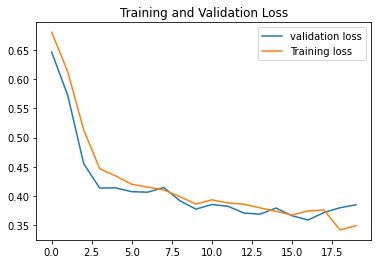

In [147]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], label="validation loss")
plt.plot(history.history['loss'], label="Training loss")
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

Text(0.5, 1.0, 'Training and Validation Accuracy')

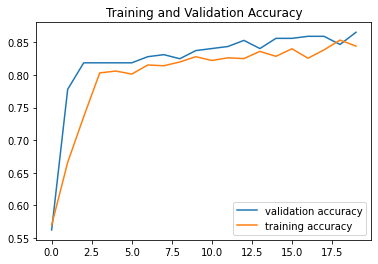

In [148]:
plt.plot(history.history['val_acc'], label="validation accuracy")
plt.plot(history.history['acc'], label="training accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

Text(0.5, 1.0, 'Training and Validation Precision')

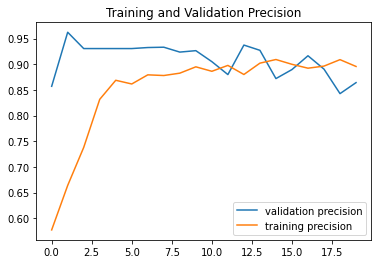

In [149]:
plt.plot(history.history['val_precision'], label="validation precision")
plt.plot(history.history['precision'], label="training precision")
plt.legend(loc='lower right')
plt.title('Training and Validation Precision')

Text(0.5, 1.0, 'Training and Validation F1 Score')

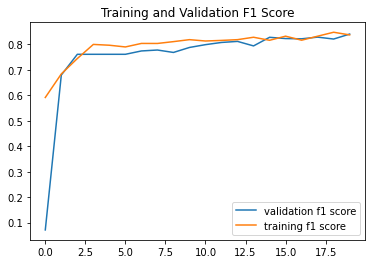

In [150]:
plt.plot(history.history['val_get_f1'], label="validation f1 score")
plt.plot(history.history['get_f1'], label="training f1 score")
plt.legend(loc='lower right')
plt.title('Training and Validation F1 Score')

Text(0.5, 1.0, 'Training and Validation Recall')

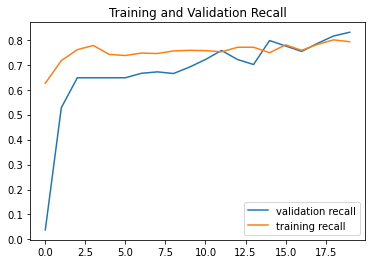

In [151]:
plt.plot(history.history['val_get_recall'], label="validation recall")
plt.plot(history.history['get_recall'], label="training recall")
plt.legend(loc='lower right')
plt.title('Training and Validation Recall')

In [152]:
print(MERGM_Record1)
print('Results: Loss = {} , Acc = {}, recall = {}, f1_score = {} '.format(MERGM_Record1[0],MERGM_Record1[1],MERGM_Record1[2],MERGM_Record1[3]))

print()
from sklearn.metrics import roc_auc_score, confusion_matrix

y_val  = val_labels
y_preds_val = MERGM.predict(VAL)
print('val auc:', roc_auc_score(y_val[:len(y_preds_val)], y_preds_val))

y_test  = test_labels
y_preds_test = MERGM.predict(TEST)
print('test auc', roc_auc_score(y_test[:len(y_preds_test)], y_preds_test))
print()
print(confusion_matrix(y_test[:len(y_preds_test)], y_preds_test>0.5))

[0.3643879294395447, 0.9221907258033752, 0.875, 0.8969696760177612, 0.8677979707717896, 0.8806537389755249]
Results: Loss = 0.3643879294395447 , Acc = 0.9221907258033752, recall = 0.875, f1_score = 0.8969696760177612 

val auc: 0.9146798029556651
test auc 0.9225833038973272

[[132  17]
 [ 23 148]]


In [157]:
from sklearn.metrics import classification_report

target_names = ['class 0', 'class 1']
print(classification_report(y_test[:len(y_preds_test)], y_preds_test>0.5, target_names=target_names, digits=4))

              precision    recall  f1-score   support

     class 0     0.8516    0.8859    0.8684       149
     class 1     0.8970    0.8655    0.8810       171

    accuracy                         0.8750       320
   macro avg     0.8743    0.8757    0.8747       320
weighted avg     0.8759    0.8750    0.8751       320



(array([856.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 904.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

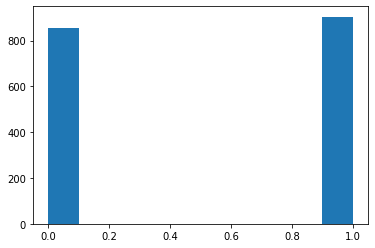

In [153]:
plt.hist(labels)